In [1]:
# Importing the header
import networkx as nx
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from numpy import linalg as LA
from neo4j import GraphDatabase
import datetime
import sys


In [2]:

def neo4jReturn(cypherTxt):

    results = driver.session().run(cypherTxt)
    nodes = list(results.graph()._nodes.values())
    rels = list(results.graph()._relationships.values())

    return (nodes, rels)


# Function to find the second eigen vector - fiedler vector
def find_second_small_eig(vector):

    second_index = 0
    min_value = vector.min()
    second_value = vector.max()
    for index in range(len(vector)):
        if vector[index] > min_value and vector[index] < second_value:
            second_index = index
            second_value = vector[index]
    return second_index


# Function to compare the low conductance
def mycmp(x, y):

    if int(x) > int(y):
        return 1
    return -1


# Function to cluster the graph
# based on fiedler vector
def spectral_clustering(G):

    starttime = datetime.datetime.now()
    # Cluster numbers
    k_clustering = 3 
    clustering_count = 1
    clusters = []

    clusters.append(list(G.nodes))

    for iter in range(k_clustering - 1):

        # Constructing Laplacian Matrix L
        large_size = 0
        large_index = 0

        for i in range(len(clusters)):
            length = len(clusters[i])
            if length > large_size:
                large_index = i
                large_size = length

        cluster_nodes = clusters[large_index]
        sub_G = G.subgraph(cluster_nodes)
        A = nx.to_numpy_matrix(sub_G)

        D = np.diag([d for n, d in sub_G.degree()])
        L = D - A

        w, v = LA.eig(L)
        second_index = 0

        # Find the second Eigen vector
        second_small_index = find_second_small_eig(w)

        index = 0
        sum = 0
        degrees = [n for n, d in sub_G.degree()]
        part1 = []
        part2 = []


        # Based on selected K nodes repeat the loop
        for i in v[:,second_small_index]:
            sum += i[0]
            if i > 0:
                part1.append(degrees[index])
            else:
                part2.append(degrees[index])
            index += 1


        clusters.remove(cluster_nodes)
        clusters.append(part1)
        clusters.append(part2)


    return k_clustering, clusters

# Function to assign different color to clusters
def coloring_clusters(k_clustering, clusters, G):

    # Coloring the clusters
    colors = ['green', 'blue', 'red', 'chocolate', 'gray',
              'cyan', 'magenta', 'lime', 'yellow', 'indigo',
              'palegreen', 'pink', 'olive', 'purple', 'slategray',
              'orange', 'tomato', 'teal', 'darkgreen', 'lightsalmon']

    color_dict = {}
    f = open("cluster.txt", "a")
    f.write("For the total Number of cluster " + str(k_clustering))
    f.write("\n \n \n")
    for i in range(k_clustering): 

        # Storing the cluster values in a file
        f = open("cluster.txt", "a")
        f.write("cluster " + str(i+1) + " : "  \
                   + str(len({ j : colors[i] for j in clusters[i]})))
        
        f.write("\n")
        color_dict = {**color_dict, **{ j : colors[i] for j in clusters[i]}}

    f.write("\n \n \n")
    f.close()


    color_map = []
    for node in G:
        color_map.append(color_dict[node])

    plt.figure(figsize=(15,10))  
    pos = nx.kamada_kawai_layout(G)
    nx.draw(G, pos, edge_color = "grey", node_color=color_map, font_weight='bold')
    plt.savefig('colored_graph_l_20.pdf')    
    plt.show()

    plt.figure(figsize=(15,10))  
    pos = nx.kamada_kawai_layout(G)
    nx.draw(G, pos, node_color=color_map,
            edge_color = "grey",
            with_labels=True, font_weight='bold')
    
    plt.savefig('colored_graph_labels_20.pdf')    
    plt.show()


def pagerank(G):

    pr = nx.pagerank(DiG, alpha=0.85)
    pr_bigsize = [v * 50e3 for v in pr.values()]
    pr_size = [round(v,4) * 50e3 for v in pr.values()]
#     print(pr_size)
#     names = dict(DiG.nodes.data('name'))
    values = {i:"{:.4f}".format(j) for i, j in zip(range(0,416), list(pr.values()))}
    
    names = {dict(G.nodes.data('name'))[i]:"{:.4f}".format(j) \
             for i, j in zip(range(0,416), list(pr.values()))}
    
    plt.figure(figsize=(20,15))    
    pos = nx.kamada_kawai_layout(DiG)
    nx.draw(DiG, pos, with_labels=True,
            edge_color = "grey",
            font_weight='bold')
    plt.show()
    
    plt.figure(figsize=(20,15)) 
    nx.draw(DiG, pos, node_size=pr_size,
            edge_color = "grey",
            with_labels=True, font_weight='bold')
    plt.show()
    
    plt.figure(figsize=(20,15))    
    nx.draw(DiG, pos, node_size=pr_bigsize, 
            edge_color = "grey",
            with_labels=True, font_weight='bold')
    
    plt.savefig('PageRank_graph.pdf') 
    plt.show()
    return names


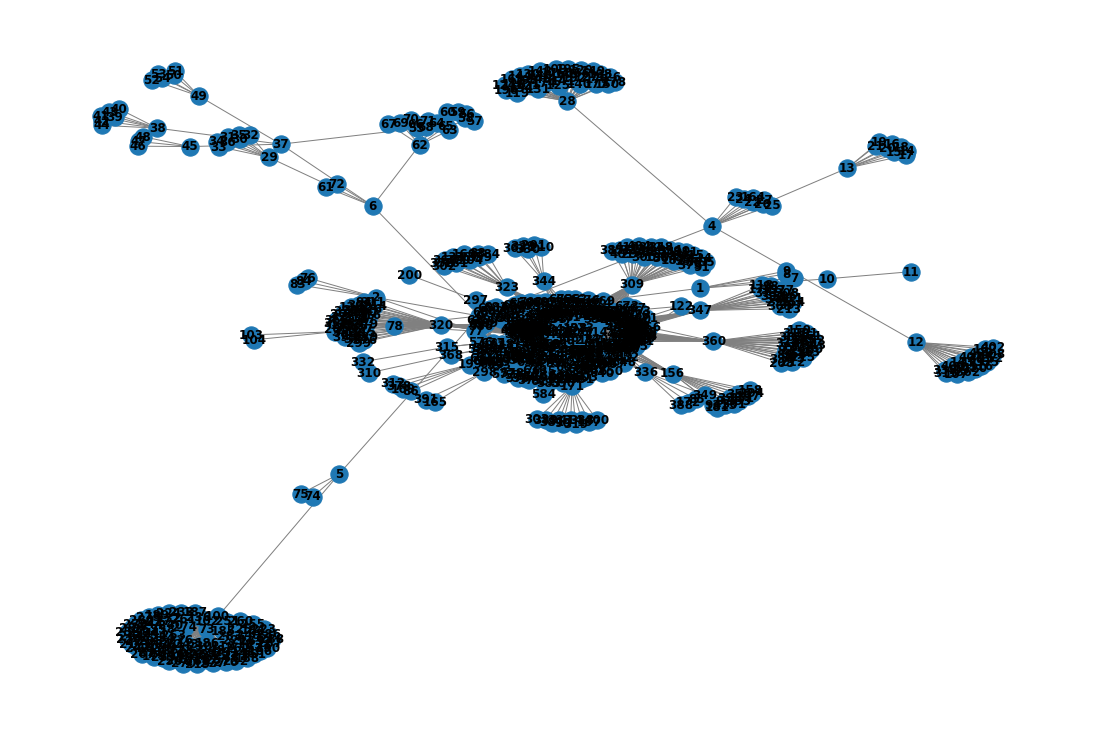

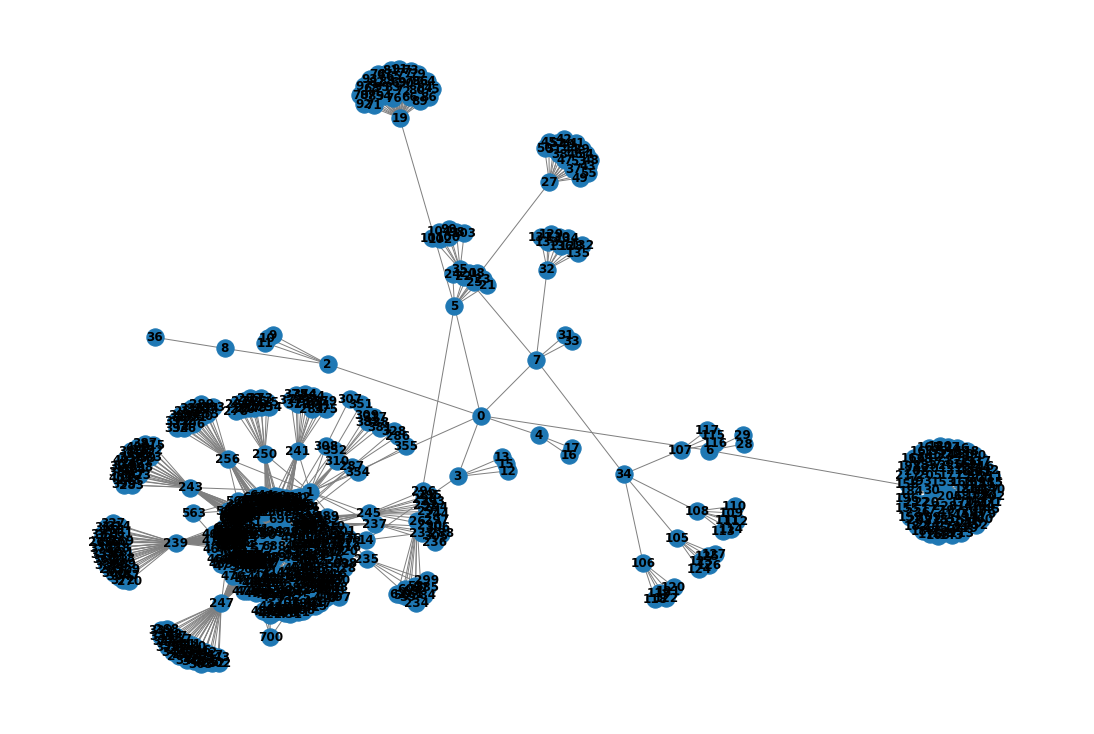

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


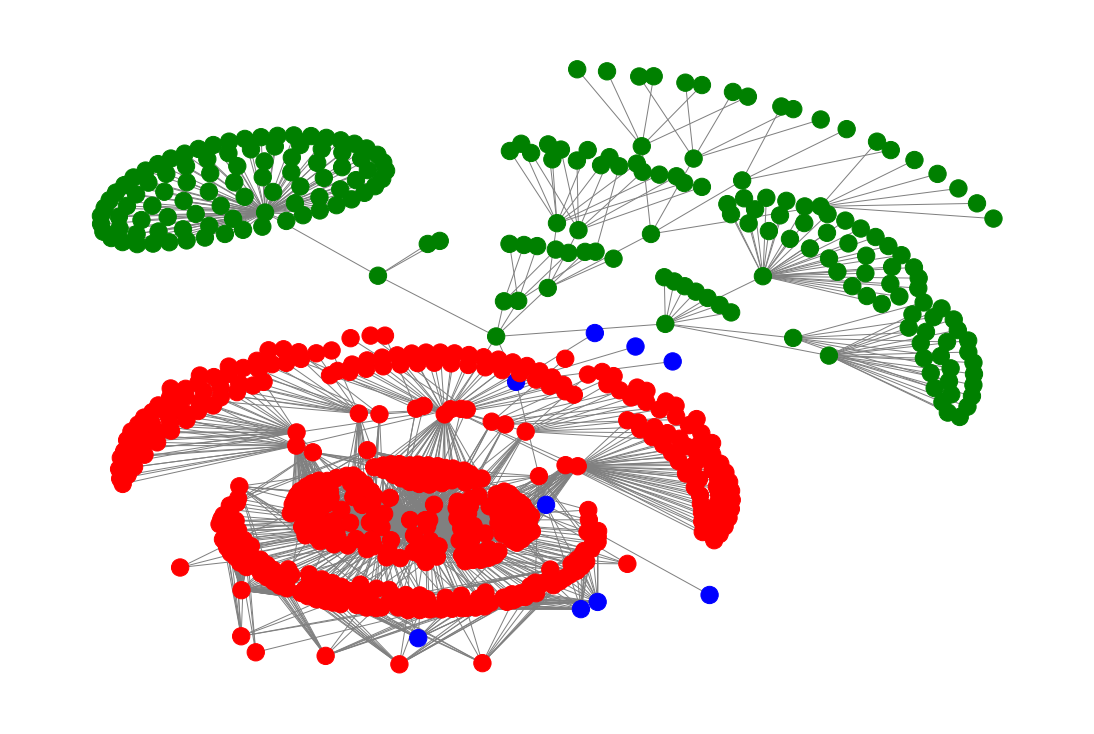

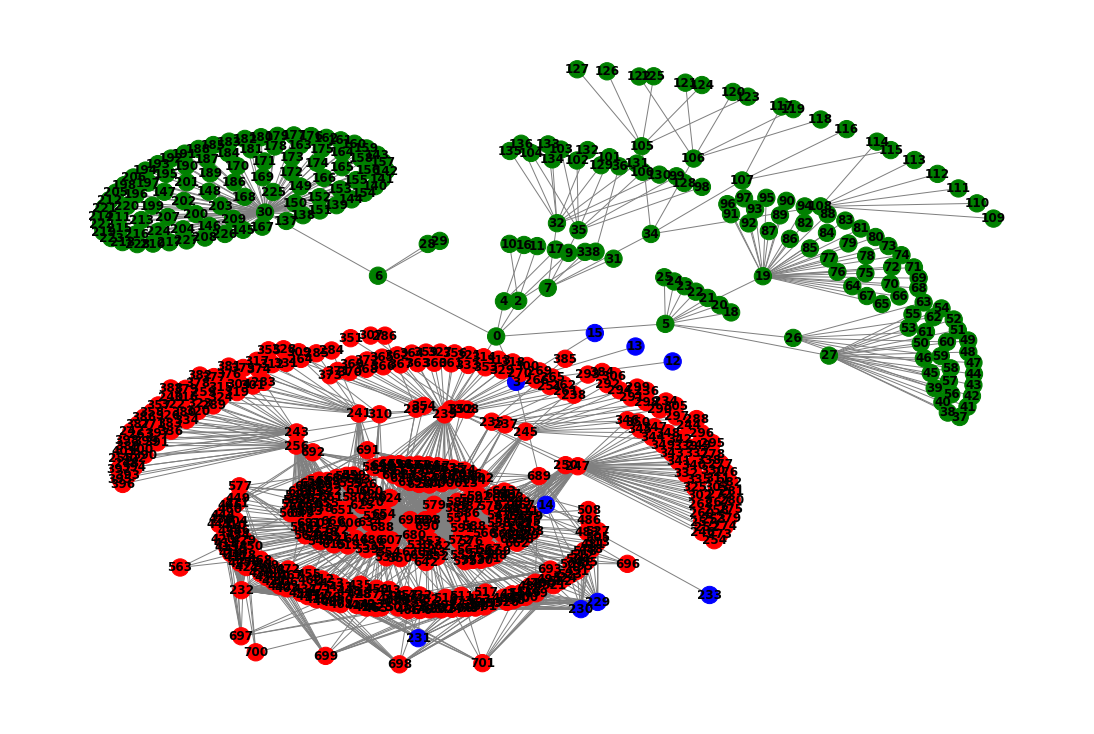

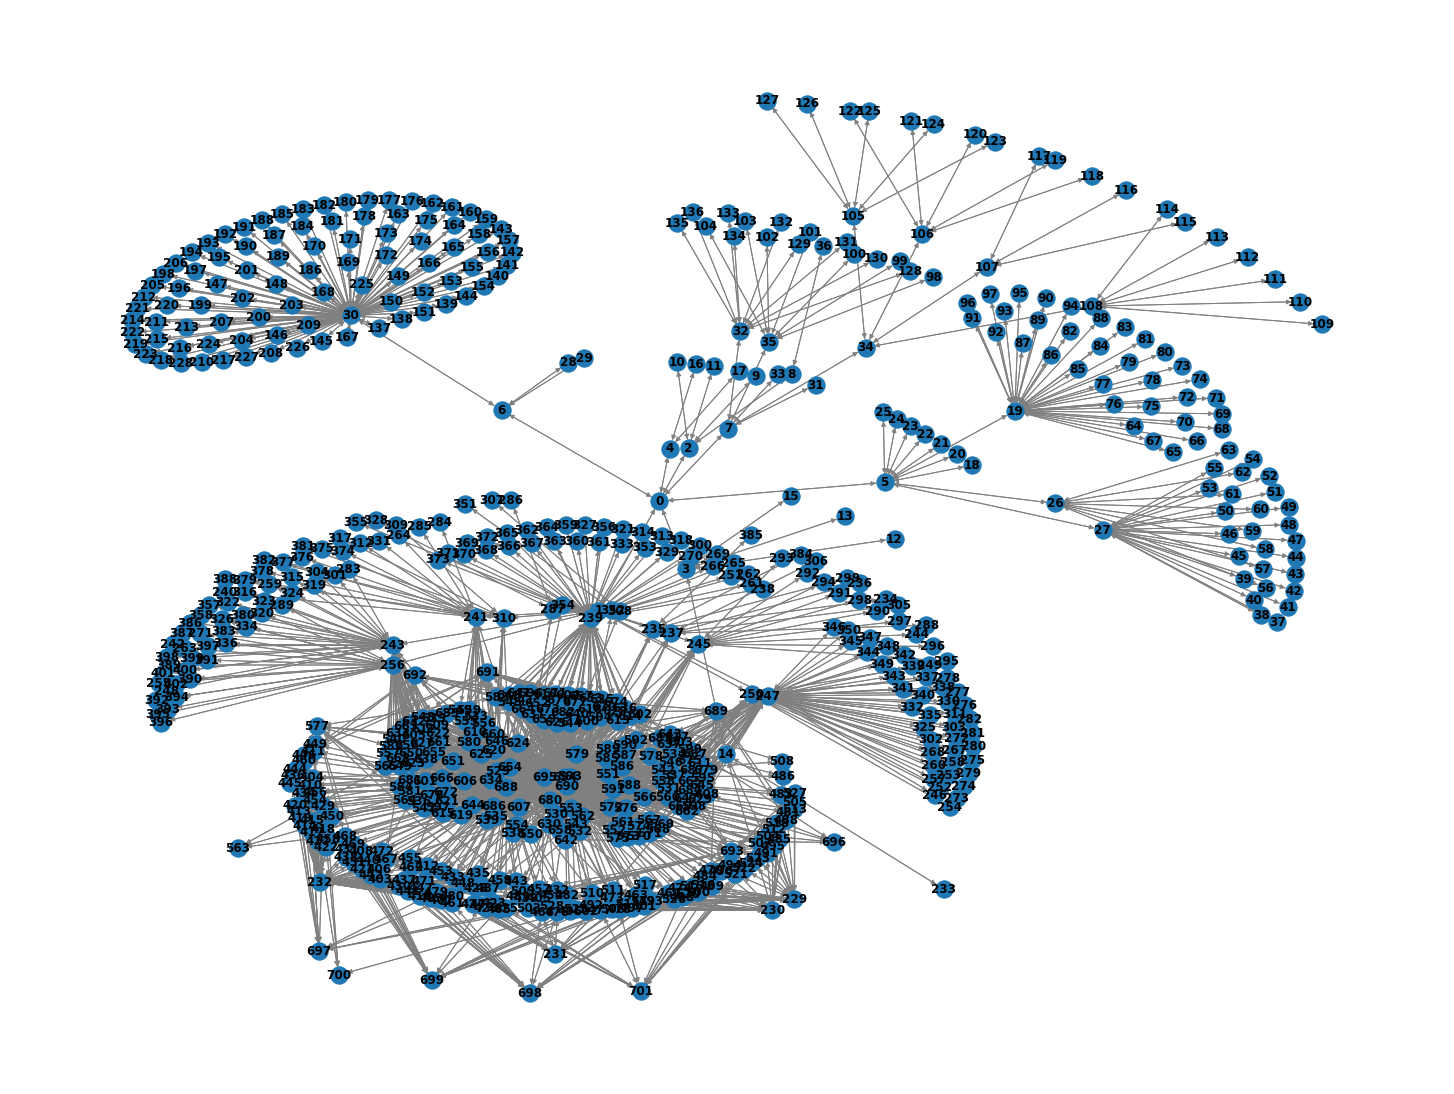

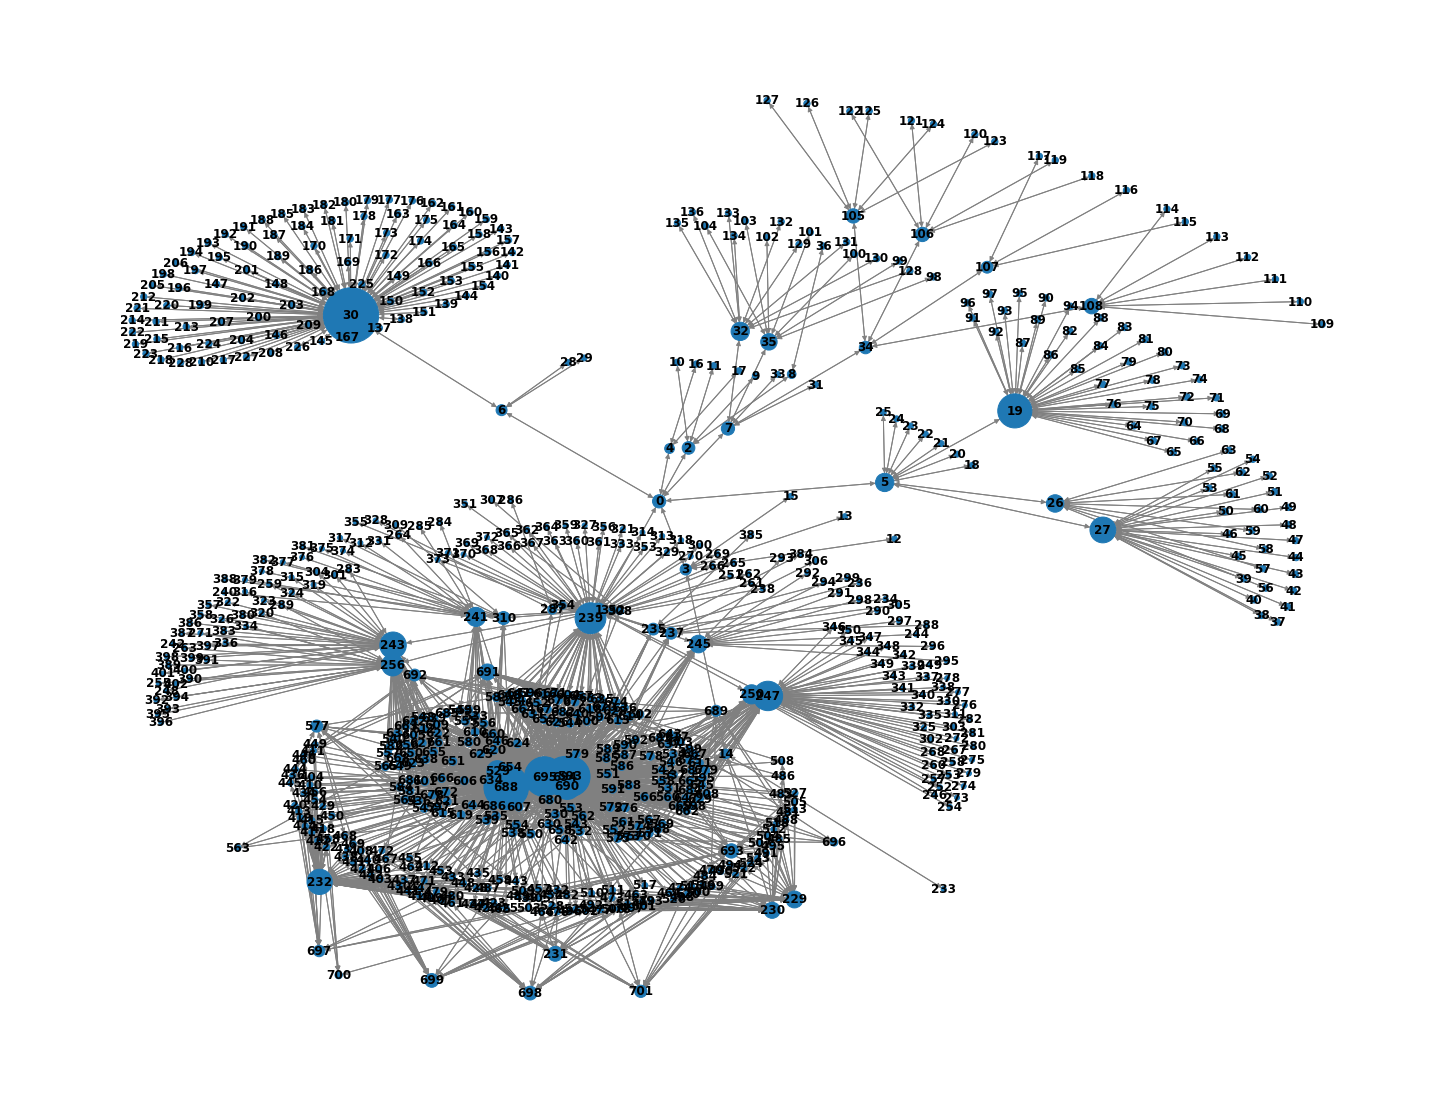

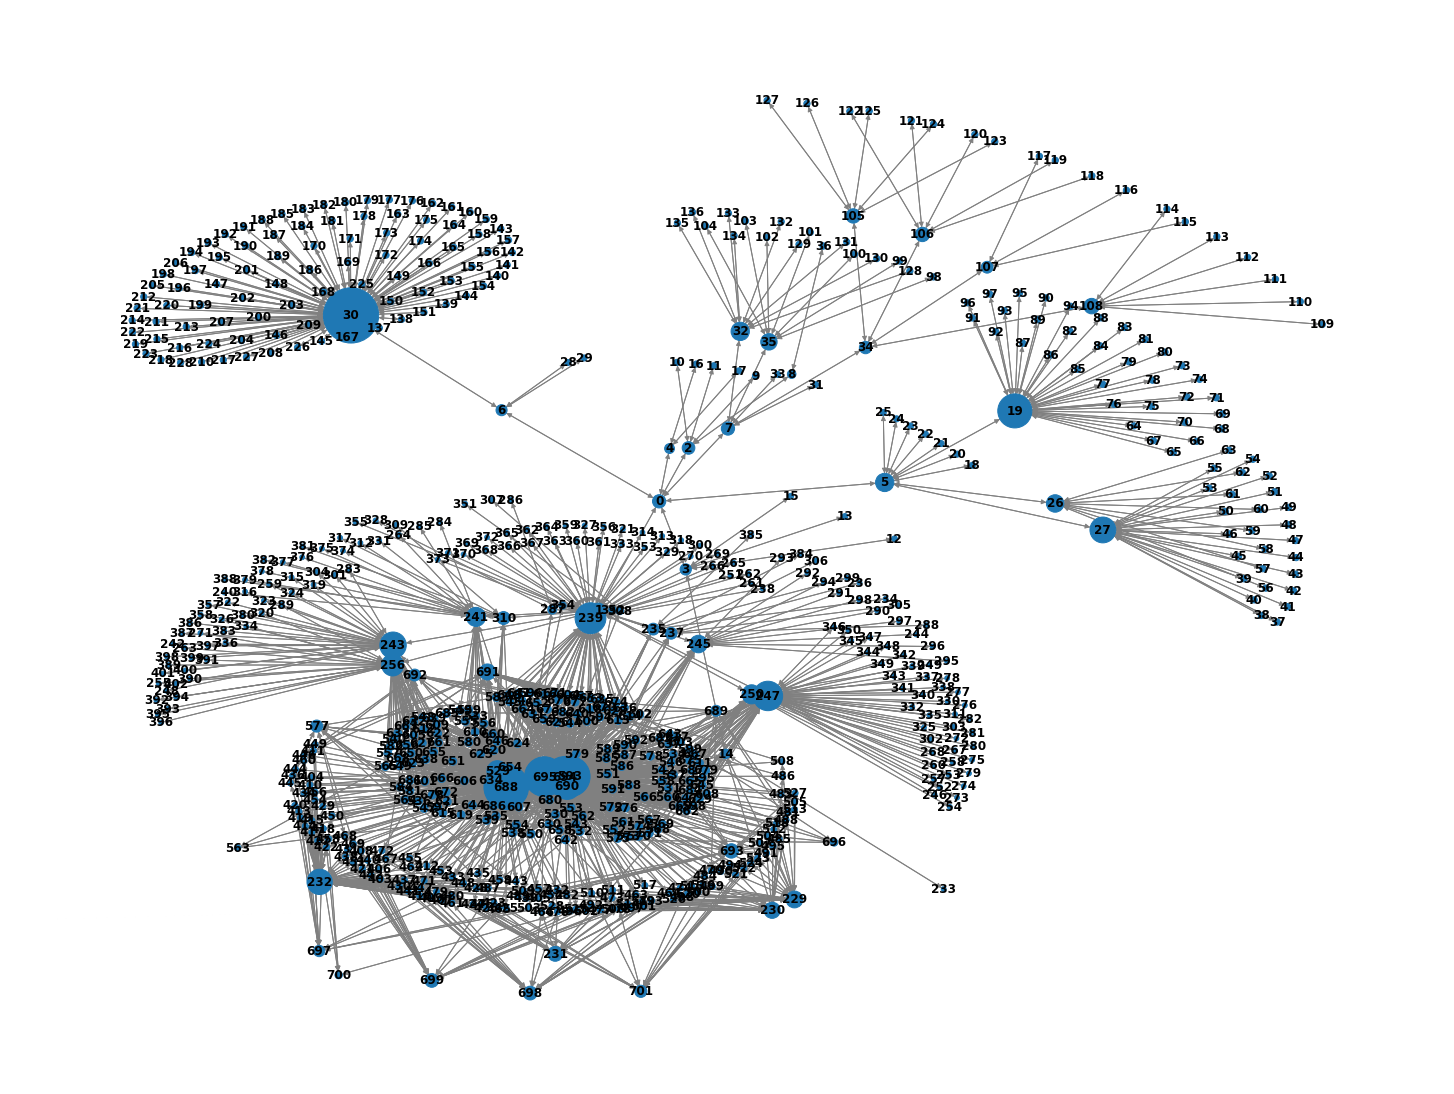

NameError: name 'G1' is not defined

In [3]:
# Main function
if __name__ == '__main__':
    
    # Connecting to Neo4j
    driver = GraphDatabase.driver(
        uri="bolt://localhost:4687", 
        auth=("neo4j", "euroncap"))
    
    # Query to get the nodes
    txt = """
        //html page 
        match (p)-[r]-()
        return p, r
        """
    
    # Getting all the nodes and relation
    nodes, rels = neo4jReturn(txt)
    # Creating the empty graph
    G = nx.Graph()

    # Get all the nodes with the properties
    for node in nodes:
        try:
            try:
                node_name = node._properties['page_name']
            except:
                try:
                    node_name = node._properties['resultpage_name']
                except:
                    try:
                        node_name = node._properties['class_name']
                    except:
                        node_name = node._properties['vehicle_name']
                        
            label, = node._labels
            G.add_node(node.id, name=node_name, 
                       properties=node._properties, 
                       label=label)  
        except:
            pass
        
    # Get all the realtions of the node
    for rel in rels:
        G.add_edge(
            rel.start_node.id,
            rel.end_node.id,
            color='k',
            key=rel.id, type=rel.type, 
            properties=rel._properties)
    
    # Plot the graph as in Neo4j
    plt.figure(figsize=(15,10))
    nx.draw(G, with_labels=True, edge_color = "grey", font_weight='bold')
    plt.savefig('graph.pdf')
    
    # Plot the relabelled graph
    G = nx.convert_node_labels_to_integers(G, first_label=0)    
    plt.figure(figsize=(15,10))
    nx.draw(G, with_labels=True, edge_color = "grey", font_weight='bold')
    plt.savefig('relabelled_graph.pdf')
    
    plt.show()
    
    
    # Spectral Clustering

    k_clustering, clusters = spectral_clustering(G)

    # Coloring the clusters
        
    coloring_clusters(k_clustering, clusters, G)

    # Converting to directed graph
    DiG = G.to_directed()
        
    #Pagerank
    names = pagerank(DiG)
#         Saving the graph
     

In [4]:
print("Saving", G)
nx.write_gpickle(G, "EuroNcap graph")
nx.write_gpickle(DiG, "EuroNcap_dir graph") 

Saving Graph with 702 nodes and 1710 edges


In [4]:
print(G)
print(DiG)

Graph with 353 nodes and 552 edges
DiGraph with 353 nodes and 1104 edges


In [5]:
adj_matrix = nx.adjacency_matrix(G).toarray()
adj_matrix

/tmp/ipykernel_22805/3510261682.py:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_matrix = nx.adjacency_matrix(G).toarray()


array([[0, 1, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [6]:
lap_matrix = nx.laplacian_matrix(G).toarray()
lap_matrix

<class 'networkx.utils.decorators.argmap'> compilation 12:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


array([[ 1, -1,  0, ...,  0,  0,  0],
       [-1, 93,  0, ...,  0,  0,  0],
       [ 0,  0,  1, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ..., 51,  0,  0],
       [ 0,  0,  0, ...,  0, 51,  0],
       [ 0,  0,  0, ...,  0,  0, 51]])

In [7]:
in_degrees = G.degree()
print(in_degrees)

[(0, 1), (1, 93), (2, 1), (3, 3), (4, 1), (5, 19), (6, 1), (7, 20), (8, 14), (9, 7), (10, 9), (11, 5), (12, 7), (13, 9), (14, 5), (15, 11), (16, 7), (17, 3), (18, 31), (19, 3), (20, 3), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 6), (74, 5), (75, 11), (76, 5), (77, 4), (78, 3), (79, 1), (80, 10), (81, 1), (82, 5), (83, 8), (84, 2), (85, 1), (86, 1), (87, 1), (88, 1), (89, 35), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1), (96, 9), (97, 1), (98, 1), (99, 6), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1), (105, 1), (106, 1), (107, 1), (108, 1), (109, 1), 

In [8]:
eig_cen = nx.eigenvector_centrality(G)
eig_cen

{0: 1.0795887791107145e-06,
 1: 1.5741251436578817e-05,
 2: 0.0005755270544194817,
 3: 0.008391636182013081,
 4: 0.004520334814302588,
 5: 0.0659100295828441,
 6: 6.942985560215058e-07,
 7: 1.0123417898524218e-05,
 8: 0.02639800659055786,
 9: 0.0018644911202092417,
 10: 0.02890671114983101,
 11: 0.015098853693439425,
 12: 0.021935942382877528,
 13: 0.02890671114983101,
 14: 0.015098853693439425,
 15: 0.03601511930895285,
 16: 0.021935942382877528,
 17: 0.008391636182013081,
 18: 0.11566445657372848,
 19: 0.008391636182013081,
 20: 0.008391636182013081,
 21: 0.007932663255300773,
 22: 0.004520334814302588,
 23: 0.0005755270544194817,
 24: 0.0019825209244266812,
 25: 0.0019825209244266812,
 26: 0.0010355309266054562,
 27: 6.942985560215058e-07,
 28: 0.0019825209244266812,
 29: 0.001504441807497946,
 30: 0.007932663255300773,
 31: 0.001504441807497946,
 32: 0.007932663255300773,
 33: 0.0010355309266054562,
 34: 0.0005755270544194817,
 35: 0.004520334814302588,
 36: 0.001504441807497946,
 

In [9]:
sorted_values = sorted(names.items(), reverse=True, key=lambda x: x[1])

print("PageRank value", "\t", "Node i'd")
for i in sorted_values:
    
    print(i[1], "\t\t", i[0], "\t\t")

PageRank value 	 Node i'd
0.1217 		 press-releases 		
0.0461 		 euro-ncap-advanced-rewards 		
0.0265 		 latest-safety-ratings 		
0.0212 		 None 		
0.0191 		 Small Family Car 		
0.0134 		 ratings-rewards 		
0.0134 		 the-rewards-explained 		
0.0122 		 best-in-class-cars 		
0.0119 		 Supermini 		
0.0107 		 safety-campaigns 		
0.0090 		 result 		
0.0083 		 protocols 		
0.0073 		 en 		
0.0072 		 Small Off-Road 		
0.0070 		 vehicle-safety 		
0.0064 		 about-euro-ncap 		
0.0063 		 for-engineers 		
0.0061 		 the-ratings-explained 		
0.0060 		 Small MPV 		
0.0060 		 Large Off-Road 		
0.0049 		 press-media 		
0.0048 		 Large MPV 		
0.0048 		 Roadster sports 		
0.0039 		 contact 		
0.0036 		 Executive 		
0.0036 		 Large Family Car 		
0.0029 		 members-and-test-facilities 		
0.0023 		 Pick-up 		
0.0023 		 Business and Family Van 		
0.0023 		 Small Mpv 		
0.0023 		 Large Off-Road 4x4 		
0.0017 		 list-of-euro-ncap-members-and-test-facilities 		
0.0016 		 15467 		
0.0016 		 ?selectedClasses=1198 		